In [1]:
import glob, os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import utils
import statistics

In [2]:
from pathlib import Path
current_working_directory = Path.cwd()

In [3]:
DATAPATH = f"{current_working_directory}/../data/server_data.csv"

In [4]:
data = pd.read_csv(DATAPATH)
utils.clean_and_format_df(data)

In [5]:
data = data.dropna(subset=['LLC-load-misses_percent'])
data = data.dropna(subset=['execution_time'])

In [6]:
# Convert to KJ and add Total Energy
data['PACKAGE_ENERGY (J)'] = data['PACKAGE_ENERGY (J)'] / 1000
data['DRAM_ENERGY (J)'] = data['DRAM_ENERGY (J)'] / 1000
data['PP0_ENERGY (J)'] = data['PP0_ENERGY (J)'] / 1000
data['TOTAL_ENERGY'] = data['PACKAGE_ENERGY (J)'] + data['DRAM_ENERGY (J)']
data['CACHE_ENERGY'] = data['PACKAGE_ENERGY (J)'] - data['PP0_ENERGY (J)']
data['execution_time'] = data['execution_time'] / 60
data['LLC-hits_percent'] = ((data['LLC-loads'] - data['LLC-load-misses']) / data['LLC-loads']) * 100

data.rename(
    columns={'PACKAGE_ENERGY (J)': 'PACKAGE_ENERGY (KJ)', 'DRAM_ENERGY (J)': 'DRAM_ENERGY (KJ)', 'PP0_ENERGY (J)': 'PP0_ENERGY (KJ)' }, inplace=True
)

In [7]:
#subjects = list(set(data['subject'].values))
subjects = ['cpython', 'pypy', 'numba', 'pyston-lite', 'py3.13-jit', 'nuitka', 'cython', 'codon', 'mypyc']
targets = ['mandelbrot', 'fannkuch_redux', 'binary_trees', 'n_body', 'spectralnorm', 'k_nucleotide', 'fasta']
GROUPS = list(
    product(list(set(subjects) - {'cpython'}), targets)
)

In [8]:
def pearson_correlation(x, y):
    # Convert inputs to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Calculate the mean of x and y
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Calculate the numerator
    numerator = np.sum((x - x_mean) * (y - y_mean))
    
    # Calculate the denominator
    denominator = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
    
    # Calculate the correlation coefficient
    correlation = numerator / denominator
    
    return correlation

In [9]:
rows = []
for x in subjects:
    energy = data[(data['subject'] == x)]['TOTAL_ENERGY'].to_list()
    time = data[(data['subject'] == x)]['execution_time'].to_list()
    correlation = pearson_correlation(energy, time)
    row = {'subject': x , 'correlation': correlation}
    rows.append(row)
    
pd.DataFrame(rows)

,subject,correlation
0,cpython,0.998221
1,pypy,0.996821
2,numba,0.997361
3,pyston-lite,0.998408
4,py3.13-jit,0.999214
5,nuitka,0.996620
6,cython,0.996332
7,codon,0.998718
8,mypyc,0.999608


In [10]:
def get_cache_correlation(data):
    rows = []
    for subject in subjects:
        for target in targets:
            df = utils.get_rows_by_subject_target(data, subject, target)
            
            utils.clean_and_format_df(df)
            df = df.dropna(subset=['LLC-load-misses_percent'])
            df = df.dropna(subset=['execution_time'])
            
            cache = df['LLC-load-misses_percent'].to_list()
            time = df['execution_time'].astype(float).to_list()
            
            correlation = pearson_correlation(cache, time)
            row = {'subject': x , 'target': target, 'correlation': correlation}
            
            rows.append(row)
    
    return pd.DataFrame(rows)

In [11]:
SERVER = f"{current_working_directory}/../data/server_data.csv"
NUC = f"{current_working_directory}/../data/nuc_data.csv"

server_data = pd.read_csv(SERVER)
nuc_data = pd.read_csv(NUC)

In [12]:
server_cache_correlation = get_cache_correlation(server_data)
nuc_cache_correlation = get_cache_correlation(nuc_data)

/home/xeder/Projects/python-compilers-rep-pkg/notebooks/utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')
/home/xeder/Projects/python-compilers-rep-pkg/notebooks/utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')
/home/xeder/Projects/python-compilers-rep-pkg/notebooks/utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [13]:
colors = [
    "#FF6B6B",  # Coral Red
    "#4ECDC4",  # Turquoise
    "#FFA07A",  # Light Salmon
    "#6A3D9A",  # Purple
    "#FFD700",  # Gold
    "#45B7D1",  # Sky Blue
    "#98D8C8",  # Mint
    "#FF69B4",  # Hot Pink
    "#8B4513"   # Saddle Brown
]

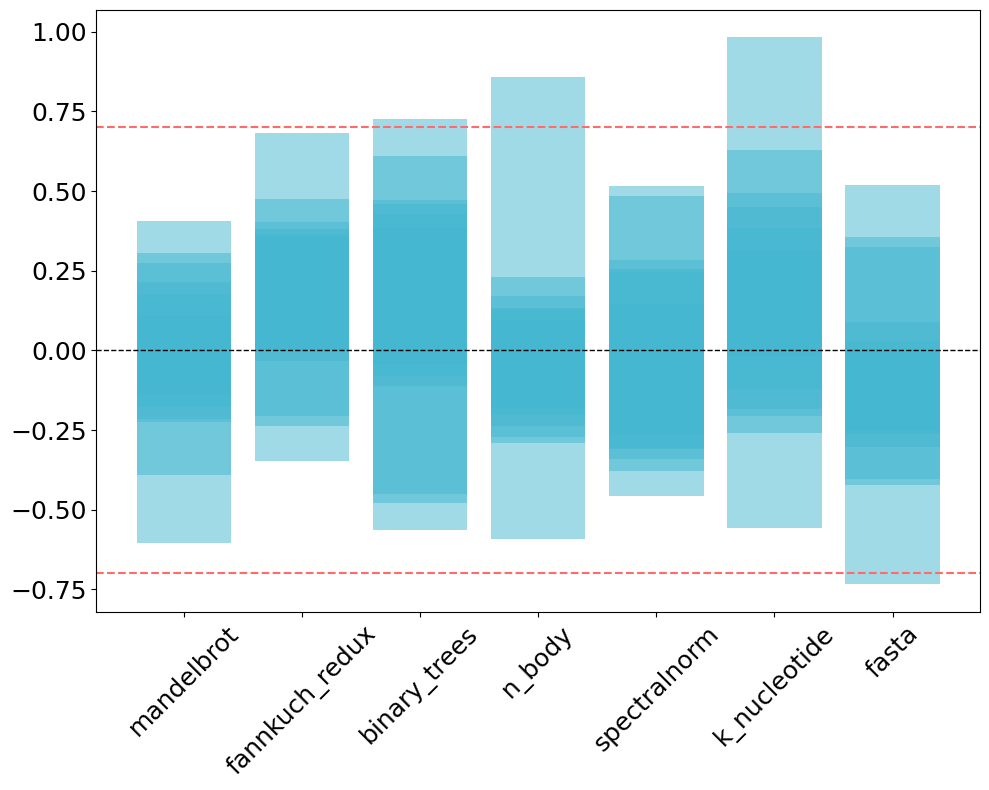

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

server = pd.DataFrame(server_cache_correlation)
nuc = pd.DataFrame(nuc_cache_correlation)

df_combined = pd.concat([server, nuc], ignore_index=True)

plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=18)

plt.bar(df_combined['target'], df_combined['correlation'], alpha=0.5, color="#45B7D1")

plt.axhline(y=0.70, color='#FF6B6B', linestyle='--', linewidth=1.5, label='Strong Correlation (0.70)')
plt.axhline(y=-0.70, color='#FF6B6B', linestyle='--', linewidth=1.5, label='Strong Correlation (0.70)')

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()

plt.savefig(f"cache_execution_correlation.pdf", dpi=300)
plt.show()